In [1]:
f# Import library
from numpy import loadtxt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
scaler = MinMaxScaler()

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import LeaveOneGroupOut, GroupShuffleSplit,GridSearchCV,\
    cross_val_score, cross_val_predict, ShuffleSplit,learning_curve, train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc,fbeta_score,\
    make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

# Load the data
subj_cond = pd.read_table('../Build_DB/subj_cond3.txt', delimiter=",") # unique subjects and their condition
df1 = pd.read_table('../Build_DB/dataframe_stress3.txt', delimiter=",") # dataframe stress
# shuffle datasets
df = df1.sample(frac=1, random_state=1).reset_index(drop=False) 

bad_subj = {41, 42,55, 59, 60, 61, 66, 71, 82,87,90,91,97,98,100,114, 115,121,129,130,131,134,136,138, 147,149,
            153, 154,159,163,171, 170, 173,174,
            35,67,69,77,79,83,85,86,139,146,161,166,
            125} # 3rd line:bad sub in control group ph1, subj 125 not stressed

df_good = df[~df['Subject'].isin(bad_subj)]

# data of first stress phase  
ds = df_good[((df_good.S == 0) & (df_good.Condition == 0))|((df_good.S ==1)&(df_good.Condition ==1))] 

# remove outliers of features values    
ds0 = ds[ds.S == 0]
ds1 = ds[ds.S == 1]
ds_droped0 = ds0.mask((ds0 - ds0.mean()).abs() > 3.5 * ds0.std()).dropna()
ds_droped1 = ds1.mask((ds1 - ds1.mean()).abs() > 3.5 * ds1.std()).dropna()
ds_droped = pd.concat([ds_droped0,ds_droped1])
X = ds_droped.iloc[:, 1:-3] # samples
S =  ds_droped['S'] # stress labels, S=1 stress, S= 0 control
Subject =  ds_droped['Subject']
# condition = 1 means stress then control, condition=0 means control then stress
Condition =  ds_droped['Condition'] 

print("Orig DataFrame: {}" .format(df.shape) )
print("\n")
print("first phase DataFrame: {}" .format(ds.shape) )
print("\n")
print("Removed outliers dataframe: {}".format(ds_droped.shape) )
print("\n")
print("(Samples, Features): {}".format(X.shape) )

Orig DataFrame: (1983, 70)


first phase DataFrame: (546, 70)


Removed outliers dataframe: (415, 70)


(Samples, Features): (415, 66)


In [2]:
modelxgb = XGBClassifier()
good_subj = Subject.unique()
good_subj.sort()
logo = LeaveOneGroupOut()
number_groups = logo.get_n_splits(X, S, Subject)

In [3]:
train_inds, test_inds = next(GroupShuffleSplit(test_size=.33, n_splits=2, random_state = 14).split(X, S, groups=Subject))
X_train, X_test = X.iloc[train_inds,:], X.iloc[test_inds,:]
y_train, y_test = S.iloc[train_inds], S.iloc[test_inds]
print(' shape training set: {}' .format(X_train.shape))
print(' shape test set: {}' .format(X_test.shape))
dtr = pd.DataFrame(X_train, y_train) # training data frame
dts = pd.DataFrame(X_test, y_test) # test dataframe
print('check balance in train samples: {}' .format(dtr.groupby('S').size()))
print('check balance in test samples: {}' .format(dts.groupby('S').size()))
train_subject = Subject.iloc[train_inds].unique()
test_subject = Subject.iloc[test_inds].unique()
train_subjects = Subject.iloc[train_inds]
test_subjects = Subject.iloc[test_inds]
print('number subject train: {}' .format(train_subject.shape))
print('number subject test: {}' .format(test_subject.shape))

subj_cond_tr = subj_cond[subj_cond['sub'].isin(train_subject)]
subj_cond_ts = subj_cond[subj_cond['sub'].isin(test_subject)]
print('check balance in train subjects: {}' .format(subj_cond_tr.groupby('cond').size()))
print('check balance in test subjects: {}' .format(subj_cond_ts.groupby('cond').size()))

min_max_scaler = preprocessing.MinMaxScaler()
x_trn = X_train.values #returns a numpy array
x_scaledtrn = min_max_scaler.fit_transform(x_trn)
feat_train = pd.DataFrame(x_scaledtrn)

x_tst = X_test.values #returns a numpy array
x_scaledtst = min_max_scaler.transform(x_tst)
feat_test = pd.DataFrame(x_scaledtst)

feat_train.columns=X_train.columns
feat_test.columns=X_train.columns

 shape training set: (282, 66)
 shape test set: (133, 66)
check balance in train samples: S
0    153
1    129
dtype: int64
check balance in test samples: S
0    95
1    38
dtype: int64
number subject train: (40,)
number subject test: (20,)
check balance in train subjects: cond
0    23
1    17
dtype: int64
check balance in test subjects: cond
0    14
1     6
dtype: int64


In [4]:
def adjusted_classes(y_scores, t):
    return [1 if y >= t else 0 for y in y_scores]

In [5]:
cv = GroupShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
scores_xgb = cross_val_score(modelxgb, X_train, y_train, groups=train_subjects, cv=cv)
print("CV Accuracy XGBoost: %0.4f ( %0.2f)" % (scores_xgb.mean(), scores_xgb.std()))
f1_xgb = cross_val_score(modelxgb, X_train, y_train, groups=train_subjects, cv=cv, scoring = 'f1')
print("CV F1 XGBoost: %0.4f ( %0.2f)" % (f1_xgb.mean(), f1_xgb.std()))
prec_xgb = cross_val_score(modelxgb, X_train, y_train, groups=train_subjects, cv=cv, scoring = 'precision')
print("CV Precision XGBoost: %0.4f ( %0.2f)" % (prec_xgb.mean(), prec_xgb.std()))
recall_xgb = cross_val_score(modelxgb, X_train, y_train, groups=train_subjects, cv=cv, scoring = 'recall')
print("CV Recall XGBoost: %0.4f ( %0.2f)" % (recall_xgb.mean(), recall_xgb.std()))

CV Accuracy XGBoost: 0.8740 ( 0.09)
CV F1 XGBoost: 0.8362 ( 0.12)
CV Precision XGBoost: 0.8327 ( 0.12)
CV Recall XGBoost: 0.8708 ( 0.17)


In [6]:
modelxgb.fit(X_train, y_train)
print('train Acc: {:.4f}'.format(modelxgb.score(X_train, y_train)))
proba_xgb = modelxgb.predict_proba(X_test)[:, 1]
y_pred_adj = adjusted_classes(proba_xgb, t=0.5)
print('test Acc: {:.4f}'.format(accuracy_score(y_test, y_pred_adj)))
print('test F1: {:.4f}' .format(fbeta_score(y_test, y_pred_adj,beta=1)))
print('test Prec: {:.4f}'.format(precision_score(y_test, y_pred_adj)))
print('test Recl: {:.4f}'.format(recall_score(y_test, y_pred_adj)))

train Acc: 1.0000
test Acc: 0.8947
test F1: 0.8205
test Prec: 0.8000
test Recl: 0.8421


In [7]:
import cvxpy
import shap

features = np.array(X_train.columns)
X_train_new = X_train.copy()
remaining_features = features.copy()
n_features = X_train.shape[1]
scores_mean = np.ones(n_features)
scores_std = np.ones(n_features)
rem_feat = []
x_size = 79
sel_feat = []
final_features = []

ecg_feat = features[0:16]
rsp_feat = features[16:32]
ppg_feat = features[32:61]
eda_feat = features[61:66]
# b0 is total energy capacity of battery
# Energy (e) and utilities (SHAP values, pp) are also specified
# energy fetaures
e_ecg = np.array([[0.0006, 0.0013, 0.0009, 0, 0.001, 0.0008, 0.0019, 0.002, 0.0044,
                   0.0008, 0.0018, 0.0045, 0.0906, 0.0906, 0.0906, 0.1813]])
e_rsp = np.array([[0.0001, 0.0005, 0.0001, 0.0001, 0.0001, 0.0109, 0.0109, 0.0109,
                   0.0563, 0.0337, 0.0337, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004]])
e_ppg =  np.array([[0.0006, 0.0013, 0.0009, 0, 0.001, 0.0008, 0.0019, 0.002, 0.0044,
                    0.0008, 0.0018, 0.0045, 0.0906, 0.0906, 0.0906, 0.1813, 0.0006,
                    0.0013, 0.0009, 0.0906, 0.0906, 0.0906, 0.1813, 0.0006, 0.0013,
                    0.00096, 0.0006, 0.0013, 0.0009]]) 
e_eda =  np.array([[0.02, 0.04, 0.02, 0.07, 0.07]]) 

# energy sensors, pre-processing, and filtering
es_ecg =  np.array([[6.76 ]]) 
es_rsp =  np.array([[11.1566]]) 
es_ppg =  np.array([[18.452]]) 
es_eda =  np.array([[3.2]]) 

# energy parameters
ePoin_ecg =  np.array([[0.0453]]) 
ePsd_ecg =  np.array([[166.14]]) 
eDel_rsp =  np.array([[0.7535]]) 
ePk_rsp =  np.array([[3.784]]) 
ePsd_rsp =  np.array([[3.7381]])
ePoin_ppg =  np.array([[0.0453]])
ePsd_ppg =  np.array([[166.14]])
eScl_eda =  np.array([[0.64]])

a0 = np.concatenate((e_ecg, e_rsp, e_ppg, e_eda, es_ecg, es_rsp, es_ppg, es_eda,
                     ePoin_ecg, ePsd_ecg, eDel_rsp,ePk_rsp, ePsd_rsp, ePoin_ppg,
                     ePsd_ppg, ePsd_ppg, eScl_eda), axis=1)

total_energy = np.sum(a0)

a1 = -np.ones((16,1))
a2 = np.zeros((16,1))
a3 = np.array([[0],[0],[0],[0],[0],[1],[1],[1],[1],[1],[1],[1],[0],[0],[0],[0]])
a4 = np.array([[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[1],[1],[1],[1]])

a5 = np.array([[1],[1],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]])
a6 = np.array([[0],[0],[1],[1],[1],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]])
a7 = np.array([[0],[0],[0],[0],[0],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1]])

a8 = -np.ones((29,1))
a9 = np.zeros((29,1))
a10 = np.array([[0],[0],[0],[0],[0],[1],[1],[1],[1],[1],[1],[1],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]])
a11 = np.array([[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[1],[1],[1],[1],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]])
a12 = np.array([[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[1],[1],[1],[1],[0],[0],[0],[0],[0],[0]])

a13 = -np.ones((5,1))
a14 = np.zeros((5,1))
a15 = np.array([[1],[1],[1],[1],[0]])


j = 0
constrained_energy = total_energy
while constrained_energy >= 3.27:
    print(j)
    print(constrained_energy)
    b0 = np.array([[constrained_energy]])
    modelxgb.fit(X_train, y_train)
    
    # SHAP values
    shap_values = shap.TreeExplainer(modelxgb).shap_values(X_train)
    global_shap_values = np.abs(shap_values).mean(0)
    
    #SHAP features importances I
    I_ecg = global_shap_values[0:16]
    I_rsp = global_shap_values[16:32]
    I_ppg = global_shap_values[32:61]
    I_eda = global_shap_values[61:66]
    
    
    #Variable features
    xf_ecg = cvxpy.Variable((16,1), boolean=True)
    xf_rsp = cvxpy.Variable((16,1), boolean=True)
    xf_ppg = cvxpy.Variable((29,1), boolean=True)
    xf_eda = cvxpy.Variable((5,1), boolean=True)
    #Variable sensors
    xs_ecg = cvxpy.Variable((1,1), boolean=True)
    xs_rsp = cvxpy.Variable((1,1), boolean=True)
    xs_ppg = cvxpy.Variable((1,1), boolean=True)
    xs_eda = cvxpy.Variable((1,1), boolean=True)
    #Variable parameters
    xPoin_ecg = cvxpy.Variable((1,1), boolean=True)
    xPsd_ecg = cvxpy.Variable((1,1), boolean=True)
    xDel_rsp = cvxpy.Variable((1,1), boolean=True)
    xPk_rsp = cvxpy.Variable((1,1), boolean=True)
    xPsd_rsp = cvxpy.Variable((1,1), boolean=True)
    xPoin_ppg = cvxpy.Variable((1,1), boolean=True)
    xPsd_ppg = cvxpy.Variable((1,1), boolean=True)
    xPsd2_ppg = cvxpy.Variable((1,1), boolean=True)
    xScl_eda = cvxpy.Variable((1,1), boolean=True)
    
    e_tot_ecg = e_ecg@xf_ecg + es_ecg*xs_ecg + ePoin_ecg*xPoin_ecg + ePsd_ecg*xPsd_ecg
    e_tot_rsp = e_rsp@xf_rsp + es_rsp*xs_rsp + eDel_rsp*xDel_rsp + ePk_rsp*xPk_rsp + ePsd_rsp*xPsd_rsp
    e_tot_ppg = e_ppg@xf_ppg + es_ppg*xs_ppg + ePoin_ppg*xPoin_ppg + ePsd_ppg*xPsd_ppg + ePsd_ppg*xPsd2_ppg
    e_tot_eda = e_eda@xf_eda + es_eda*xs_eda + eScl_eda*xScl_eda
    
    # Constrained optimization    
    constraints = [
        e_tot_ecg + e_tot_rsp + e_tot_ppg + e_tot_eda <= b0,
        xf_ecg + a1*xs_ecg <= a2,
        cvxpy.multiply(a3,xf_ecg) + a1*xPoin_ecg <= a2,
        cvxpy.multiply(a4,xf_ecg) + a1*xPsd_ecg <= a2,
        xf_rsp + a1*xs_rsp <= a2,
        cvxpy.multiply(a5,xf_rsp) + a1*xDel_rsp <= a2,
        cvxpy.multiply(a6,xf_rsp) + a1*xPk_rsp <= a2,
        cvxpy.multiply(a7,xf_rsp) + a1*xPsd_rsp <= a2,
        xf_ppg + a8*xs_ppg <= a9,
        cvxpy.multiply(a10,xf_ppg) + a8*xPoin_ppg <= a9,
        cvxpy.multiply(a11,xf_ppg) + a8*xPsd_ppg <= a9,
        cvxpy.multiply(a12,xf_ppg) + a8*xPsd2_ppg <= a9,
        xf_eda + a13*xs_eda <= a14,
        cvxpy.multiply(a15,xf_eda) + a13*xScl_eda <= a14,
    ]
    
    #energy_constraint = A@x <= b
    #total_utility = pp * x
    total_utility = I_ecg*xf_ecg + I_rsp*xf_rsp + I_ppg*xf_ppg + I_eda*xf_eda
    knapsack_problem = cvxpy.Problem(cvxpy.Maximize(total_utility), constraints)
    knapsack_problem.solve(solver=cvxpy.GLPK_MI)
    
    xf_ecg_value = xf_ecg.value
    e1_selected_indx =np.reshape(xf_ecg_value, 16)
    xf_rsp_value = xf_rsp.value
    e2_selected_indx =np.reshape(xf_rsp_value, 16)
    xf_ppg_value = xf_ppg.value
    e3_selected_indx =np.reshape(xf_ppg_value, 29)
    xf_eda_value = xf_eda.value
    e4_selected_indx =np.reshape(xf_eda_value, 5)
    
    xs_ecg_value = xs_ecg.value
    xs_rsp_value = xs_rsp.value
    xs_ppg_value = xs_ppg.value
    xs_eda_value = xs_eda.value
    
    xPoin_ecg_val = xPoin_ecg.value
    xPsd_ecg_val = xPsd_ecg.value
    xDel_rsp_val = xDel_rsp.value
    xPk_rsp_val = xPk_rsp.value
    xPsd_rsp_val = xPsd_rsp.value
    xPoin_ppg_val = xPoin_ppg.value
    xPsd_ppg_val = xPsd_ppg.value
    xPsd2_ppg_val = xPsd2_ppg.value
    xScl_eda_val = xScl_eda.value

    v_value = np.concatenate((xf_ecg_value, xf_rsp_value,xf_ppg_value,xf_eda_value,xs_ecg_value,
                              xs_rsp_value,xs_ppg_value,xs_eda_value,xPoin_ecg_val,xPsd_ecg_val, 
                              xDel_rsp_val,xPk_rsp_val,xPsd_rsp_val,xPoin_ppg_val,xPsd_ppg_val,
                              xPsd2_ppg_val,xScl_eda_val), axis=None) 
    
    a0_selected_indx =np.reshape(v_value, x_size)
        
    selection_indx = np.reshape(v_value[:-13], x_size-13)
    selection_indx_bool = selection_indx.astype(bool)
    selected_features = features[selection_indx_bool]
    sel_feat.insert(j, [selected_features])

    cost = np.sum(a0 * a0_selected_indx)
    I =np.sum(global_shap_values * selection_indx)
    print('Utility: {}' .format(I))
    X_train_new = X_train[selected_features]
    nsf = X_train_new.shape[1]   #  number_selected_features
    
    #Train model, CV Accuracy
    scores_xgb = cross_val_score(modelxgb, X_train_new, y_train, groups=train_subjects, cv=cv)
    scores_mean = scores_xgb.mean()
    scores_std = scores_xgb.std()
    
    f1_xgb = cross_val_score(modelxgb, X_train_new, y_train, groups=train_subjects, cv=cv, scoring = 'f1')
    f1_mean = f1_xgb.mean()
    f1_std = f1_xgb.std()
    
    prec_xgb = cross_val_score(modelxgb, X_train_new, y_train, groups=train_subjects, cv=cv ,scoring = 'precision')
    prec_mean = prec_xgb.mean()
    prec_std = prec_xgb.std()
    
    rec_xgb = cross_val_score(modelxgb, X_train_new, y_train, groups=train_subjects, cv=cv, scoring = 'recall')
    rec_mean = rec_xgb.mean()
    rec_std = rec_xgb.std()  
    
    our_acc = 'cv. acc pre-sel %.4f'% scores_mean
    our_f1 = 'cv. f1 pre-sel %.4f'% f1_mean
    our_prec = 'cv. prec pre-sel %.4f'% prec_mean
    our_rec = 'cv. recl pre-sel %.4f'% rec_mean


    num_sel_feat = " with "+str(nsf)+" pre-selected features"

    our_cost = " need "+str(cost)+" mj energy."

    print(our_acc + num_sel_feat + our_cost)
    print(our_f1)
    print(our_prec)
    print(our_rec)
    print(selected_features)
    
    # RFECV with SHAP features importances
    remaining_features2 = selected_features.copy()
    scores_mean2 = np.ones(nsf)
    scores_std2 = np.ones(nsf)
    
    f1_mean2 = np.ones(nsf)
    f1_std2 = np.ones(nsf)
    
    prec_mean2 = np.ones(nsf)
    prec_std2 = np.ones(nsf)
    
    rec_mean2 = np.ones(nsf)
    rec_std2 = np.ones(nsf)
    rem_feat2 = []
    for i in range(nsf): 
        modelxgb.fit(X_train_new, y_train)
        
        scores_xgb2 = cross_val_score(modelxgb, X_train_new, y_train, groups=train_subjects, cv=cv)
        scores_mean2[nsf-(i+1)] = scores_xgb2.mean()
        scores_std2[nsf-(i+1)] = scores_xgb2.std()
        
        f1_xgb2 = cross_val_score(modelxgb, X_train_new, y_train, groups=train_subjects, cv=cv, scoring = 'f1')
        f1_mean2[nsf-(i+1)] = f1_xgb2.mean()
        f1_std2[nsf-(i+1)] = f1_xgb2.std()
    
        prec_xgb2 = cross_val_score(modelxgb, X_train_new, y_train, groups=train_subjects, cv=cv, scoring = 'precision')
        prec_mean2[nsf-(i+1)] = prec_xgb2.mean()
        prec_std2[nsf-(i+1)] = prec_xgb2.std()
    
        rec_xgb2 = cross_val_score(modelxgb, X_train_new, y_train, groups=train_subjects, cv=cv, scoring = 'recall')
        rec_mean2[nsf-(i+1)] = rec_xgb2.mean()
        rec_std2[nsf-(i+1)] = rec_xgb2.std()
        
        shap_values2 = shap.TreeExplainer(modelxgb).shap_values(X_train_new)
        global_shap_values2 = np.abs(shap_values2).mean(0)
        sort_inds2 = np.argsort(global_shap_values2)
        
        removed_feature2 = remaining_features2[sort_inds2[0]]
        X_train_new = X_train_new.drop(removed_feature2, axis=1)
        rem_feat2.insert(i,[remaining_features2])
        remaining_features2 = np.delete(remaining_features2, sort_inds2[0],0)
        
    maximum_score = np.amax(scores_mean2)
    max_acc = 'Max CV Acc. selected feat is: %.4f'% maximum_score
    number_selected_features2 = np.where(scores_mean2 == np.amax(scores_mean2))[0][0]+1
    num_sel_feat2 = " with "+str(number_selected_features2)+" selected features."
    print(max_acc + num_sel_feat2)    
    print("cv f1: %0.4f " % f1_mean2[number_selected_features2-1])
    print("cv precision: %0.4f" % prec_mean2[number_selected_features2-1])
    print("cv Recall: %0.4f" % rec_mean2[number_selected_features2-1])
    result_ind2 = np.where(scores_mean2 == np.amax(scores_mean2))
    selected_features2=rem_feat2[nsf-result_ind2[0][0]-1][0]
    final_features.insert(j, [selected_features2])
    
    L= []
    for h, u in enumerate(selected_features2): 
        res_ind = np.where(features == u)
        L.append(res_ind[0][0])
    cost2 = np.sum(np.take(a0, L))  
    if any(y < 16 for y in L):
        cost2 = cost2+ 6.76
    if any(4< y < 12 for y in L):
        cost2 = cost2+ 0.04532
    if any(11< y < 16 for y in L):
        cost2 = cost2+ 166.14   
    if any(15< y < 32 for y in L):
        cost2 = cost2+ 11.1566
    if any(15< y < 18 for y in L):
        cost2 = cost2+ 0.7533
    if any(17< y < 21 for y in L):
        cost2 = cost2 + 3.784
    if any(20< y < 32 for y in L):
        cost2 = cost2+ 3.7381        
    if any(31< y < 61 for y in L):
        cost2 = cost2+ 18.452
    if any(36< y < 44 for y in L):
        cost2 = cost2 + 0.04532
    if any(43< y < 48 for y in L):
        cost2 = cost2+ 166.14 
    if any(50< y < 55 for y in L):
        cost2 = cost2+ 166.14 
    if any(60< y < 66 for y in L):
        cost2 = cost2+ 3.2
    if any(60< y < 65 for y in L):
        cost2 = cost2+ 0.64
    
    
    our_cost = " selected need "+str(cost2)+" mj energy."
    
    print(our_cost)
    print(selected_features2)
    print("\n")
    j +=1
    constrained_energy = cost2 -0.05


0
548.7818599999999
Utility: 7.794127652421594
cv. acc pre-sel 0.8775 with 52 pre-selected features need 548.0701599999999 mj energy.
cv. f1 pre-sel 0.8393
cv. prec pre-sel 0.8381
cv. recl pre-sel 0.8710
['ECG_RR_mean' 'ECG_RR_SDNN' 'ECG_RR_SDSD' 'ECG_RR_PNN50' 'ECG_RR_L'
 'ECG_RR_CSI_modified' 'ECG_RR_CVI' 'ECG_RR_L2' 'ECG_RR_LoT_2'
 'ECG_RR_Log10LT_2' 'ECG_RR_VLF' 'ECG_RR_HRV_LF' 'RSP_RATE_mean'
 'RSP_RATE_std' 'RSP_Pk' 'RSP_PowerPk' 'RSP_Power' 'RSP_VLF' 'RSP_LF'
 'RSP_HF' 'RSP_LFp1oHF' 'RSP_HF_gaussF1' 'RSP_HF_F1pond' 'RSP_ecgHF_pF1n'
 'RSP_ecgHF_pF2n' 'RSP_ecgHF_pF3n' 'RSP_ecgHF_pF4n' 'RSP_ecgHF_pF5n'
 'PPG_PP_mean' 'PPG_PP_SDNN' 'PPG_PP_SDSD' 'PPG_PP_CSI'
 'PPG_PP_CSI_modified' 'PPG_PP_CVI' 'PPG_PP_L2' 'PPG_PP_Log10LT_2'
 'PPG_PP_VLF' 'PPG_PP_HRV_LF' 'PPG_PP_HRV_HF' 'PPG_PRT_mean'
 'PPG_PRT_SDNN' 'PPG_PRT_HRV_LF' 'PPG_PRT_HRV_LFoHF' 'PPG_PA_mean'
 'PPG_PA_SDNN' 'PPG_PA_SDSD' 'PPG_k_mean' 'PPG_k_SDNN' 'SCL_mean'
 'SCL_std' 'SCL_gradient' 'SCR_driver_phasic_power']
Max CV Acc. sele

In [8]:
step_plusone =10
thresholds = np.linspace(0.03, 0.99, 60)
tuned_ths = np.ones(step_plusone)
# perf = np.ones(step_plusone-1)
# f1 = np.ones(step_plusone-1)
# perc = np.ones(step_plusone-1)
# rec = np.ones(step_plusone-1)
for j in range(step_plusone):
    print(j)
    f1s = []
    ps =[]
    rs =[]
    accs = []
    feat_list = final_features[j][0]
    X_train2 = X_train[feat_list]
    for i, (train_index, val_index) in enumerate(cv.split(X_train2, y_train, train_subjects)):
        X_train_tr, X_val = X_train2.iloc[train_index,:], X_train2.iloc[val_index,:]
        y_train_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        modelxgb.fit(X_train_tr, y_train_tr)
        proba_xgb = modelxgb.predict_proba(X_val)[:, 1]
        f1 = np.ones(len(thresholds))
        acc = np.ones(len(thresholds))
        p = np.ones(len(thresholds))
        r = np.ones(len(thresholds))
        for jj in range(len(thresholds)):
            th = thresholds[jj]   
            y_pred_adj = adjusted_classes(proba_xgb, t=th)
            acc[jj] = accuracy_score(y_val, y_pred_adj)
            f1[jj] = fbeta_score(y_val, y_pred_adj, beta=1)
            p[jj] = precision_score(y_val, y_pred_adj)
            r[jj] = recall_score(y_val, y_pred_adj)
        f1s.append(f1)
        ps.append(p)
        rs.append(r)
        accs.append(acc)
        
    mean_f1 = np.mean(f1s, axis =0)
    mean_p = np.mean(ps, axis =0)
    mean_r = np.mean(rs, axis =0)
    mean_acc = np.mean(accs, axis =0)
    
    std_f1 = np.std(f1s, axis =0)
    std_p = np.std(ps, axis =0)
    std_r = np.std(rs, axis =0)
    std_acc = np.std(accs, axis =0)        
   
    ind = np.where( np.absolute(mean_r-mean_p) <= 0.01)[0]
    tuned_th = thresholds[ind[0]]
    tuned_acc = mean_acc[ind[0]]
    tuned_f1 = mean_f1[ind[0]]
    tuned_p = mean_p[ind[0]]
    tuned_r = mean_r[ind[0]]
    tuned_ths[j] = tuned_th
    print("Th: %0.4f" %tuned_th)
    print("Accuracy: %0.4f" %tuned_acc)
    print("F1: %0.4f" %tuned_f1)
    print("Precision: %0.4f" %tuned_p)
    print("Recall: %0.4f" %tuned_r)
    print("\n")
    print("\n")



0
Th: 0.5019
Accuracy: 0.9028
F1: 0.8688
Precision: 0.8769
Recall: 0.8839




1
Th: 0.5344
Accuracy: 0.9039
F1: 0.8716
Precision: 0.8785
Recall: 0.8877




2
Th: 0.5832
Accuracy: 0.8952
F1: 0.8589
Precision: 0.8677
Recall: 0.8775




3
Th: 0.5181
Accuracy: 0.8971
F1: 0.8608
Precision: 0.8740
Recall: 0.8753




4
Th: 0.5344
Accuracy: 0.9040
F1: 0.8756
Precision: 0.8804
Recall: 0.8877




5
Th: 0.4856
Accuracy: 0.8948
F1: 0.8608
Precision: 0.8700
Recall: 0.8744




6
Th: 0.6158
Accuracy: 0.9021
F1: 0.8698
Precision: 0.8786
Recall: 0.8870




7
Th: 0.5507
Accuracy: 0.8752
F1: 0.8339
Precision: 0.8445
Recall: 0.8541




8
Th: 0.5669
Accuracy: 0.5798
F1: 0.4321
Precision: 0.4631
Recall: 0.4667




9
Th: 0.5344
Accuracy: 0.4713
F1: 0.3352
Precision: 0.3426
Recall: 0.3452






/home/momeni/venv3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/momeni/venv3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/momeni/venv3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/momeni/venv3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWar

In [9]:
step_plusone =10
# Train Test acc
# perf = np.ones(step_plusone-1)
# f1 = np.ones(step_plusone-1)
# perc = np.ones(step_plusone-1)
# rec = np.ones(step_plusone-1)
for j in range(step_plusone):
    print(j)
    feat_list = final_features[j][0]
    X_tr = X_train[feat_list]
    X_te = X_test[feat_list]
    
    modelxgb.fit(X_tr, y_train)
    print('Accuracy of XGB on training set: {:.4f}'
         .format(modelxgb.score(X_tr, y_train)))
    # print('Accuracy of XGB on test set: {:.4f}'
    #      .format(modelxgb.score(X_te, y_test)))
    proba_xgb = modelxgb.predict_proba(X_te)[:, 1]
    y_pred_adj = adjusted_classes(proba_xgb, t=0.5)
    print('test Accuracy: ',accuracy_score(y_test, y_pred_adj))
    print('test F1: ',fbeta_score(y_test, y_pred_adj,beta=1))
    print('test Precision: ',precision_score(y_test, y_pred_adj))
    print('test Recall: ',recall_score(y_test, y_pred_adj))
    print("\n")
    print("\n")
    # if j<=6:
    #     perf[j]= accuracy_score(y_test, y_pred_adj)
    #     f1[j]= fbeta_score(y_test, y_pred_adj,beta=1)
    #     perc[j]= precision_score(y_test, y_pred_adj)
    #     rec[j]= recall_score(y_test, y_pred_adj)

0
Accuracy of XGB on training set: 1.0000
test Accuracy:  0.8872180451127819
test F1:  0.7945205479452055
test Precision:  0.8285714285714286
test Recall:  0.7631578947368421




1
Accuracy of XGB on training set: 1.0000
test Accuracy:  0.8947368421052632
test F1:  0.8157894736842104
test Precision:  0.8157894736842105
test Recall:  0.8157894736842105




2
Accuracy of XGB on training set: 1.0000
test Accuracy:  0.8872180451127819
test F1:  0.8051948051948051
test Precision:  0.7948717948717948
test Recall:  0.8157894736842105




3
Accuracy of XGB on training set: 1.0000
test Accuracy:  0.9022556390977443
test F1:  0.8219178082191781
test Precision:  0.8571428571428571
test Recall:  0.7894736842105263




4
Accuracy of XGB on training set: 1.0000
test Accuracy:  0.8947368421052632
test F1:  0.8055555555555555
test Precision:  0.8529411764705882
test Recall:  0.7631578947368421




5
Accuracy of XGB on training set: 1.0000
test Accuracy:  0.8947368421052632
test F1:  0.8055555555555555

In [10]:
step_plusone =10
for j in range(step_plusone):
    th = tuned_ths[j]
    print(j)
    feat_list = final_features[j][0]
    X_tr = X_train[feat_list]
    X_te = X_test[feat_list]
    
    modelxgb.fit(X_tr, y_train)
    print('Accuracy of XGB on training set: {:.4f}'
         .format(modelxgb.score(X_tr, y_train)))
    proba_xgb = modelxgb.predict_proba(X_te)[:, 1]
    y_pred_adj = adjusted_classes(proba_xgb, t=th)
    print('test Accuracy tuned: ',accuracy_score(y_test, y_pred_adj))
    print('test F1 tuned : ',fbeta_score(y_test, y_pred_adj,beta=1))
    print('test Precisiontuned : ',precision_score(y_test, y_pred_adj))
    print('test Recall tuned: ',recall_score(y_test, y_pred_adj))
    print("\n")
    print("\n")

0
Accuracy of XGB on training set: 1.0000
test Accuracy tuned:  0.8872180451127819
test F1 tuned :  0.7945205479452055
test Precisiontuned :  0.8285714285714286
test Recall tuned:  0.7631578947368421




1
Accuracy of XGB on training set: 1.0000
test Accuracy tuned:  0.8947368421052632
test F1 tuned :  0.8157894736842104
test Precisiontuned :  0.8157894736842105
test Recall tuned:  0.8157894736842105




2
Accuracy of XGB on training set: 1.0000
test Accuracy tuned:  0.8721804511278195
test F1 tuned :  0.7733333333333334
test Precisiontuned :  0.7837837837837838
test Recall tuned:  0.7631578947368421




3
Accuracy of XGB on training set: 1.0000
test Accuracy tuned:  0.9022556390977443
test F1 tuned :  0.8219178082191781
test Precisiontuned :  0.8571428571428571
test Recall tuned:  0.7894736842105263




4
Accuracy of XGB on training set: 1.0000
test Accuracy tuned:  0.8947368421052632
test F1 tuned :  0.8055555555555555
test Precisiontuned :  0.8529411764705882
test Recall tuned:  0.7

In [62]:
def step_info(t,yout):
    result = []
    #for i in range(2,len(yout)-1):
    for i in range(len(yout)-1):
        dif = abs(yout[-1]-yout[i])
        delta = dif/yout[-1]
        if delta < 0.02 :
            result.append(i)
    return result

In [69]:
j =9
from sklearn.model_selection import validation_curve
y_trainn = np.reshape(y_train.values,[len(y_train),])
step_plusone = j+1
params = {
    'objective': 'binary:logistic',
    'max_depth': 3, 
    'learning_rate': 0.1, #0.01, n_esti = 1000 -> tran acc & test acc get closer but at 1000 tree
}
n_est_max_cv = np.ones(step_plusone)
n_est_enough_cv = np.ones(step_plusone)
n_estimators_range = np.linspace(1, 100, 100).astype('int')
for j in range(step_plusone):
    print(j)
    f1s = []
    ps =[]
    rs =[]
    accs = []
    feat_list = final_features[j][0]
    X_tr = X_train[feat_list]
    train_scores, validation_scores = validation_curve(
    XGBClassifier(**params),
    X_tr, y_trainn,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    groups=train_subjects,
    cv=cv,
    scoring='accuracy'
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)
    i = np.argmax(validation_scores_mean)
    max_cv = validation_scores_mean[i]
    n_est_max_cv[j] = n_estimators_range[i]
    
    result = []
    for i in range(len(validation_scores_mean)):
        dif = abs(max_cv-validation_scores_mean[i])
        delta = dif/max_cv
        if delta < 0.02 :
            result.append(i)
            
    #i_enough = step_info(n_estimators_range,validation_scores_mean)
    i_enough = result[0]
    enough_cv = validation_scores_mean[i_enough]
    n_est_enough_cv[j] = n_estimators_range[i_enough]

    print('best num trees: ',n_est_max_cv[j])
    print('max cv acc: ',max_cv)
    print('enough num trees: ',n_est_enough_cv[j])
    print('enough cv acc: ',enough_cv)

0
best num trees:  85.0
max cv acc:  0.9008557924230935
enough num trees:  10.0
enough cv acc:  0.8843256000299162
1
best num trees:  88.0
max cv acc:  0.9059056571965893
enough num trees:  16.0
enough cv acc:  0.8885403943945537
2
best num trees:  78.0
max cv acc:  0.8968955241052402
enough num trees:  10.0
enough cv acc:  0.8790280549760278
3
best num trees:  85.0
max cv acc:  0.9025496823202502
enough num trees:  31.0
enough cv acc:  0.8878333466026602
4
best num trees:  77.0
max cv acc:  0.9001994545703482
enough num trees:  11.0
enough cv acc:  0.8823622334750135
5
best num trees:  94.0
max cv acc:  0.8986317212910573
enough num trees:  14.0
enough cv acc:  0.8858105093370824
6
best num trees:  96.0
max cv acc:  0.8953267654688686
enough num trees:  8.0
enough cv acc:  0.8791506039956356
7
best num trees:  64.0
max cv acc:  0.8739920438322057
enough num trees:  1.0
enough cv acc:  0.8595869115279691
8
best num trees:  19.0
max cv acc:  0.6370991381572162
enough num trees:  17.0
en

In [77]:
step_plusone =10
mean_f1_max = np.ones(step_plusone)
mean_p_max = np.ones(step_plusone)
mean_r_max = np.ones(step_plusone)
mean_acc_max = np.ones(step_plusone)

std_f1_max = np.ones(step_plusone)
std_p_max = np.ones(step_plusone)
std_r_max = np.ones(step_plusone)
std_acc_max = np.ones(step_plusone)
for j in range(step_plusone):
    print(j)
    f1s = []
    ps =[]
    rs =[]
    accs = []
    feat_list = final_features[j][0]
    X_train2 = X_train[feat_list]
    n_est_max = n_est_max_cv[j].astype('int')
    #n_est_engh = n_est_enough_cv[j].astype('int')
    for i, (train_index, val_index) in enumerate(cv.split(X_train2, y_train, train_subjects)):
        X_train_tr, X_val = X_train2.iloc[train_index,:], X_train2.iloc[val_index,:]
        y_train_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        params = {
        'n_estimators': n_est_max
         }
        maxmodel = XGBClassifier(**params).fit(X_train_tr, y_train_tr)
        y_pred = maxmodel.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        f1 = fbeta_score(y_val, y_pred, beta=1)
        p = precision_score(y_val, y_pred)
        r = recall_score(y_val, y_pred)
        accs.append(acc)
        f1s.append(f1)
        ps.append(p)
        rs.append(r)      
    mean_f1_max[j] = np.mean(f1s, axis =0)
    mean_p_max[j] = np.mean(ps, axis =0)
    mean_r_max[j] = np.mean(rs, axis =0)
    mean_acc_max[j] = np.mean(accs, axis =0)
    
    std_f1_max[j] = np.std(f1s, axis =0)
    std_p_max[j] = np.std(ps, axis =0)
    std_r_max[j] = np.std(rs, axis =0)
    std_acc_max[j] = np.std(accs, axis =0)        

    print("Accuracy: %0.4f" %mean_acc_max[j])
    print("F1: %0.4f" %mean_f1_max[j])
    print("Precision: %0.4f" %mean_p_max[j])
    print("Recall: %0.4f" %mean_r_max[j])
    print("\n")

0
Accuracy: 0.9009
F1: 0.8668
Precision: 0.8730
Recall: 0.8839


1
Accuracy: 0.9059
F1: 0.8742
Precision: 0.8793
Recall: 0.8925


2
Accuracy: 0.8969
F1: 0.8634
Precision: 0.8628
Recall: 0.8885


3
Accuracy: 0.9025
F1: 0.8699
Precision: 0.8758
Recall: 0.8877


4
Accuracy: 0.9002
F1: 0.8695
Precision: 0.8705
Recall: 0.8877


5
Accuracy: 0.8986
F1: 0.8653
Precision: 0.8779
Recall: 0.8744


6
Accuracy: 0.8953
F1: 0.8621
Precision: 0.8587
Recall: 0.8920


7
Accuracy: 0.8740
F1: 0.8362
Precision: 0.8266
Recall: 0.8731


8
Accuracy: 0.6371
F1: 0.5787
Precision: 0.5386
Recall: 0.7015


9
Accuracy: 0.4643
F1: 0.3459
Precision: 0.3581
Recall: 0.3994




In [78]:
step_plusone =10
mean_f1_engh = np.ones(step_plusone)
mean_p_engh = np.ones(step_plusone)
mean_r_engh = np.ones(step_plusone)
mean_acc_engh = np.ones(step_plusone)

std_f1_engh = np.ones(step_plusone)
std_p_engh = np.ones(step_plusone)
std_r_engh = np.ones(step_plusone)
std_acc_engh = np.ones(step_plusone)
for j in range(step_plusone):
    print(j)
    f1s = []
    ps =[]
    rs =[]
    accs = []
    feat_list = final_features[j][0]
    X_train2 = X_train[feat_list]
    n_est_engh = n_est_enough_cv[j].astype('int')
    for i, (train_index, val_index) in enumerate(cv.split(X_train2, y_train, train_subjects)):
        X_train_tr, X_val = X_train2.iloc[train_index,:], X_train2.iloc[val_index,:]
        y_train_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        params = {
        'n_estimators': n_est_engh
         }
        enghmodel = XGBClassifier(**params).fit(X_train_tr, y_train_tr)
        y_pred = enghmodel.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        f1 = fbeta_score(y_val, y_pred, beta=1)
        p = precision_score(y_val, y_pred)
        r = recall_score(y_val, y_pred)
        accs.append(acc)
        f1s.append(f1)
        ps.append(p)
        rs.append(r)      
    mean_f1_engh[j] = np.mean(f1s, axis =0)
    mean_p_engh[j] = np.mean(ps, axis =0)
    mean_r_engh[j] = np.mean(rs, axis =0)
    mean_acc_engh[j] = np.mean(accs, axis =0)
    
    std_f1_engh[j] = np.std(f1s, axis =0)
    std_p_engh[j] = np.std(ps, axis =0)
    std_r_engh[j] = np.std(rs, axis =0)
    std_acc_engh[j] = np.std(accs, axis =0)        

    print("Accuracy: %0.4f" %mean_acc_engh[j])
    print("F1: %0.4f" %mean_f1_engh[j])
    print("Precision: %0.4f" %mean_p_engh[j])
    print("Recall: %0.4f" %mean_r_engh[j])
    print("\n")

0
Accuracy: 0.8843
F1: 0.8538
Precision: 0.8505
Recall: 0.8789


1
Accuracy: 0.8885
F1: 0.8543
Precision: 0.8553
Recall: 0.8747


2
Accuracy: 0.8790
F1: 0.8385
Precision: 0.8390
Recall: 0.8680


3
Accuracy: 0.8878
F1: 0.8557
Precision: 0.8472
Recall: 0.8877


4
Accuracy: 0.8824
F1: 0.8481
Precision: 0.8325
Recall: 0.8908


5
Accuracy: 0.8858
F1: 0.8547
Precision: 0.8451
Recall: 0.8861


6
Accuracy: 0.8792
F1: 0.8405
Precision: 0.8297
Recall: 0.8835


7
Accuracy: 0.8596
F1: 0.8107
Precision: 0.8319
Recall: 0.8396


8
Accuracy: 0.6285
F1: 0.5621
Precision: 0.5380
Recall: 0.6704


9
Accuracy: 0.4557
F1: 0.3226
Precision: 0.3461
Recall: 0.3516




In [80]:
# Train Test acc

step_plusone =10
tes_max_acc = np.ones(step_plusone)
tes_max_f1 = np.ones(step_plusone)
tes_max_p = np.ones(step_plusone)
tes_max_r = np.ones(step_plusone)
for j in range(step_plusone):
    print(j)
    feat_list = final_features[j][0]
    X_tr = X_train[feat_list]
    X_te = X_test[feat_list]
    n_est_max = n_est_max_cv[j].astype('int')
    params = {
        'n_estimators': n_est_max
         }
    model = XGBClassifier(**params).fit(X_tr, y_train)
    print('Accuracy of XGB on training set: {:.4f}'
         .format(model.score(X_tr, y_train)))
    y_pred = model.predict(X_te)
    tes_max_acc[j] = accuracy_score(y_test, y_pred)
    tes_max_f1[j] = fbeta_score(y_test, y_pred, beta=1)
    tes_max_p[j] = precision_score(y_test, y_pred)
    tes_max_r[j] = recall_score(y_test, y_pred)
    print('test Accuracy: ',tes_max_acc[j])
    print('test F1: ',tes_max_f1[j])
    print('test Precision: ',tes_max_p[j])
    print('test Recall: ',tes_max_r[j])
    print("\n")
    print("\n")

0
Accuracy of XGB on training set: 1.0000
test Accuracy:  0.8872180451127819
test F1:  0.7945205479452055
test Precision:  0.8285714285714286
test Recall:  0.7631578947368421




1
Accuracy of XGB on training set: 1.0000
test Accuracy:  0.8947368421052632
test F1:  0.8157894736842104
test Precision:  0.8157894736842105
test Recall:  0.8157894736842105




2
Accuracy of XGB on training set: 1.0000
test Accuracy:  0.8872180451127819
test F1:  0.8051948051948051
test Precision:  0.7948717948717948
test Recall:  0.8157894736842105




3
Accuracy of XGB on training set: 1.0000
test Accuracy:  0.9022556390977443
test F1:  0.8219178082191781
test Precision:  0.8571428571428571
test Recall:  0.7894736842105263




4
Accuracy of XGB on training set: 1.0000
test Accuracy:  0.8947368421052632
test F1:  0.8055555555555555
test Precision:  0.8529411764705882
test Recall:  0.7631578947368421




5
Accuracy of XGB on training set: 1.0000
test Accuracy:  0.8947368421052632
test F1:  0.8055555555555555

In [81]:
# Train Test acc

step_plusone =10
tes_engh_acc = np.ones(step_plusone)
tes_engh_f1 = np.ones(step_plusone)
tes_engh_p = np.ones(step_plusone)
tes_engh_r = np.ones(step_plusone)
for j in range(step_plusone):
    print(j)
    feat_list = final_features[j][0]
    X_tr = X_train[feat_list]
    X_te = X_test[feat_list]
    n_est_engh = n_est_enough_cv[j].astype('int')
    params = {
        'n_estimators': n_est_engh
         }
    model = XGBClassifier(**params).fit(X_tr, y_train)
    print('Accuracy of XGB on training set: {:.4f}'
         .format(model.score(X_tr, y_train)))
    y_pred = model.predict(X_te)
    tes_engh_acc[j] = accuracy_score(y_test, y_pred)
    tes_engh_f1[j] = fbeta_score(y_test, y_pred, beta=1)
    tes_engh_p[j] = precision_score(y_test, y_pred)
    tes_engh_r[j] = recall_score(y_test, y_pred)
    print('test Accuracy: ',tes_engh_acc[j])
    print('test F1: ',tes_engh_f1[j])
    print('test Precision: ',tes_engh_p[j])
    print('test Recall: ',tes_engh_r[j])
    print("\n")
    print("\n")

0
Accuracy of XGB on training set: 0.9752
test Accuracy:  0.8571428571428571
test F1:  0.7532467532467534
test Precision:  0.7435897435897436
test Recall:  0.7631578947368421




1
Accuracy of XGB on training set: 0.9929
test Accuracy:  0.8721804511278195
test F1:  0.7733333333333334
test Precision:  0.7837837837837838
test Recall:  0.7631578947368421




2
Accuracy of XGB on training set: 0.9823
test Accuracy:  0.8646616541353384
test F1:  0.7631578947368421
test Precision:  0.7631578947368421
test Recall:  0.7631578947368421




3
Accuracy of XGB on training set: 0.9965
test Accuracy:  0.9022556390977443
test F1:  0.8266666666666665
test Precision:  0.8378378378378378
test Recall:  0.8157894736842105




4
Accuracy of XGB on training set: 0.9610
test Accuracy:  0.849624060150376
test F1:  0.7435897435897436
test Precision:  0.725
test Recall:  0.7631578947368421




5
Accuracy of XGB on training set: 0.9787
test Accuracy:  0.8721804511278195
test F1:  0.7792207792207793
test Precisio

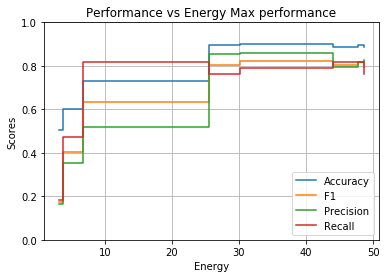

In [85]:
x = [48.6, 47.8, 44.1, 30.1, 29.3, 26.3, 25.6, 6.8, 3.8, 3.2]
plt.figure()
# fig = plt.figure(dpi=200)
# ax = fig.add_subplot(1, 1, 1)
plt.title('Performance vs Energy Max performance')
plt.ylim(bottom =0, top=1)
plt.xlabel("Energy")
plt.ylabel("Scores")
# Major ticks every 10, minor ticks every 2
# major_ticks = np.arange(0, 55, 10)
# minor_ticks = np.arange(0, 55, 2)

# ax.set_xticks(major_ticks)
# ax.set_xticks(minor_ticks, minor=True)
# ax.set_yticks(major_ticks)
# ax.set_yticks(minor_ticks, minor=True)
# ax.grid(which='both', alpha = 0.5)
plt.step(x, tes_max_acc,label="Accuracy")
plt.step(x, tes_max_f1,label="F1")
plt.step(x, tes_max_p,label="Precision")
plt.step(x, tes_max_r,label="Recall")
plt.legend(loc='best')

#plt.figure(figsize=(8, 8))
# plt.title("Performance vs Energy")
# plt.plot(thresholds, mean_p, "b--", label="Precision")
# plt.plot(thresholds, mean_r, "g-", label="Recall")
# 
# plt.ylabel("Score")
# plt.xlabel("Decision Threshold")
plt.grid()
# plt.legend(loc='best')
# plt.fill_between(thresholds, mean_f1 - std_f1,mean_f1 + std_f1, alpha=0.1, color="y")
# plt.fill_between(thresholds, mean_p - std_p,
#                      mean_p + std_p, alpha=0.1,
#                      color="b")
#plt.savefig("perf_vs_eng_17_4.png", bbox_inches = 'tight')
plt.show()

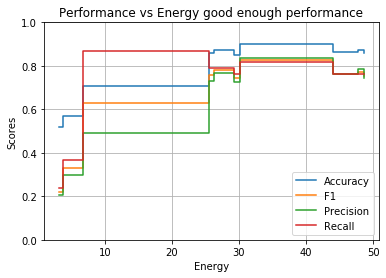

In [86]:
x = [48.6, 47.8, 44.1, 30.1, 29.3, 26.3, 25.6, 6.8, 3.8, 3.2]
plt.figure()

plt.title('Performance vs Energy good enough performance')
plt.ylim(bottom =0, top=1)
plt.xlabel("Energy")
plt.ylabel("Scores")

plt.step(x, tes_engh_acc,label="Accuracy")
plt.step(x, tes_engh_f1,label="F1")
plt.step(x, tes_engh_p,label="Precision")
plt.step(x, tes_engh_r,label="Recall")
plt.legend(loc='best')

plt.grid()

plt.show()

/home/momeni/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/home/momeni/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


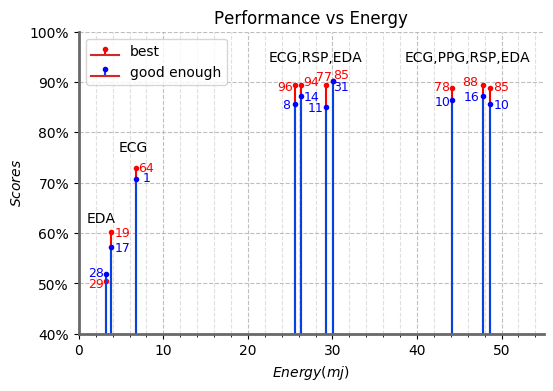

In [209]:
import matplotlib.ticker as mtick

eng = [48.6, 47.8, 44.1, 30.1, 29.3, 26.3, 25.6, 6.8, 3.8, 3.2]
n = [10, 16,10,31,11,14,8,1,17,28]
plt.figure(figsize=(6,4), dpi= 100)

plt.title('Performance vs Energy', fontdict={'size':12})
plt.xlim(0,55)
plt.ylim(bottom =0.4, top=1)
#plt.yticks(fontsize=12, alpha=.7)
plt.xlabel('$Energy (mj)$')
plt.ylabel('$Scores$')
# Major ticks every 10, minor ticks every 2
major_ticks = np.arange(0, 55, 10)
minor_ticks = np.arange(0, 55, 2)

plt.gca().set_xticks(major_ticks)
plt.gca().set_xticks(minor_ticks, minor=True)
# ax.set_yticks(major_ticks)
# ax.set_yticks(minor_ticks, minor=True)

plt.stem(eng, tes_max_acc,label="best",markerfmt ="r.",linefmt='r')# ,linefmt='green'
plt.stem(eng, tes_engh_acc,label="good enough",markerfmt ="b.",linefmt='xkcd:blue')

# for x, y, tex in zip (eng,tes_engh_acc, n):
#     k = plt.text(x,y,tex, horizontalalignment ='center',
#          verticalalignment ='center',color='white', fontsize=8,
#                  bbox=dict(facecolor='#2c6faa',edgecolor='azure', boxstyle='circle'))


e1 = [50, 46.4, 43, 31, 28,27.5, 24.5, 8, 5.2, 2]
s1 = [0.855, 0.87, 0.86, 0.89, 0.848, 0.87, 0.855, 0.71, 0.57, 0.52]
n1 =[10, 16, 10,31,11,14,8, 1,17,28]

e2 =[50,46.3,43,31,29,27.5,24.4,8,5.2,2 ]
s2 =[0.89, 0.90, 0.89, 0.915, 0.91, 0.90, 0.89, 0.73, 0.60, 0.50 ]
n2 =[85,88,78,85,77,94,96,64,19,29]

# [0.86 0.87 0.86 0.90 0.85 0.87, 0.86 0.71 0.57 0.52]
# [0.89 0.89 0.89 0.90 0.89 0.89, 0.89 0.73 0.60 0.50 ]
for x, y, tex in zip (e1,s1, n1):
    k = plt.text(x,y,tex, horizontalalignment ='center',
         verticalalignment ='center',color='b', fontsize=9)

for x, y, tex in zip (e2,s2, n2):
    k = plt.text(x,y,tex, horizontalalignment ='center',
         verticalalignment ='center',color='r', fontsize=9)

plt.text(46,0.95,'ECG,PPG,RSP,EDA', ha = 'center', va = 'center')
plt.text(28,0.95,'ECG,RSP,EDA', ha = 'center', va = 'center')
plt.text(6.5,0.77,'ECG', ha = 'center', va = 'center')
plt.text(2.7,0.63,'EDA', ha = 'center', va = 'center')

plt.legend(loc='best')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().spines["left"].set_linewidth(2)
plt.gca().spines["left"].set_color("dimgray")
plt.gca().spines["bottom"].set_linewidth(2)
plt.gca().spines["bottom"].set_color("dimgray")
plt.grid(which='major',linestyle='--', alpha=0.8) # which = 'both'
plt.grid(which='minor',linestyle='--', alpha=0.4)

# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
#plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
#plt.gca().spines["left"].set_alpha(0.3)   

plt.show()

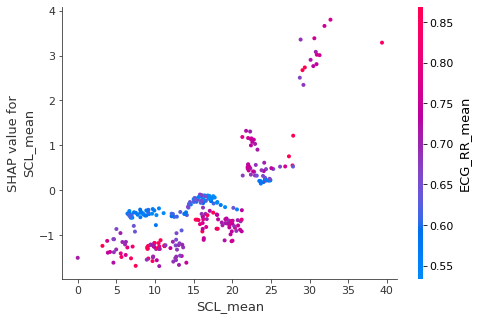

In [219]:
import shap
feat_list = final_features[0][0]
x = X_train[feat_list]
params = {
    'n_estimators': 85
     }
model = XGBClassifier(**params).fit(x, y_train)
model.fit(x,y_train)
shap_values = shap.TreeExplainer(model).shap_values(x)
#shap.summary_plot(shap_values, X_train)
shap.dependence_plot("SCL_mean", shap_values, x, interaction_index="ECG_RR_mean" ,show=False)

#shap.summary_plot(shap_values, X_train, plot_type="bar",max_display=7,show=False)

